In [4]:
import gurobipy as gb 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json


You need to load in your Gurobi license info (paste it into a config.json file) or else the code below won't run at all because of license limitations.

In [5]:
with open('config.json', 'r') as config_file:
    options = json.load(config_file)
    
grb_env = gb.Env(params=options)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2601656
Academic license 2601656 - for non-commercial use only - registered to ab___@student-cs.fr


# Data

We work with the 4 Sales Reps, 22 Bricks data here but given some changes here to load in the data for the "Pfitzer 10,100" the code below works.

In [6]:
N = 4
M = 22

In [7]:
brick_indices = pd.read_csv('./data/bricks_index_values.csv')
distances_df = pd.read_excel('./data/distances.xlsx', sheet_name='brick-brick', usecols="C:X", skiprows=1)

In [8]:
distances_df.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,0.000000,7.353258,13.208755,16.159669,18.219385,16.683252,14.003832,19.022245,17.447017,28.486721,...,24.528583,24.094136,25.383225,24.293812,23.233883,23.698122,8.475966,13.845739,5.237194,21.120353
1,7.353258,0.000000,6.575409,19.000329,20.060199,19.064367,16.300702,21.588353,21.449886,30.986005,...,25.984799,26.473492,28.221837,27.224160,26.252522,26.271829,8.079431,8.361800,9.146857,17.330058
2,13.208755,6.575409,0.000000,25.293843,26.050850,25.242300,22.536115,27.759038,27.928323,36.986085,...,31.680357,32.498003,34.365455,33.407055,32.472254,32.361721,14.181241,10.961756,15.719574,12.247094
3,16.159669,19.000329,25.293843,0.000000,3.069544,1.219262,2.796319,2.872716,3.799224,12.348279,...,8.819597,7.935320,9.337858,8.289656,7.280000,7.550265,11.126801,17.492090,11.028259,36.120000
4,18.219385,20.060199,26.050850,3.069544,0.000000,1.915646,4.221718,2.354782,6.186857,10.943843,...,6.311022,6.447154,8.403910,7.548649,6.769202,6.346416,11.984824,17.217680,12.986216,37.368839


In [9]:
sr_center_initial = np.zeros((N, M))
sr_center_initial[0,3] = 1
sr_center_initial[1,13] = 1
sr_center_initial[2,15] = 1
sr_center_initial[3,21] = 1

distances = np.array(distances_df.values.tolist())
workloads = np.array([brick_indices["index_value"].iloc[i] for i in range(22)])

## Biobjective model

In this first scenario, the positions of the center bricks are variable and we try to optimize for the distance and workload

In [23]:
def solve_epsilon(epsilon_value, distance_sq, workload):
    model = gb.Model(f"BiObj_eps_{epsilon_value}",env=grb_env)

    # =============== Variables ===============
    x = model.addVars(N, M, vtype=gb.GRB.BINARY, name="x")  # Assign bricks
    c = model.addVars(N, M, vtype=gb.GRB.BINARY, name="c")  # Center bricks

    # =============== Objective 1: total distance ===============
    #    distance_objective = sum_{i in reps} sum_{k in bricks} sum_{j in bricks}
    #            [distance_sq[k,j] * x[i,j] * c[i,k]]
    distance_objective = gb.quicksum(
        distance_sq[k, j] * x[i, j] * c[i, k]
        for i in range(N)
        for k in range(M)
        for j in range(M)
    )

    workload_per_SR = [gb.quicksum(workload[j] * x[i, j] for j in range(M)) for i in range(N)]

    # =============== Objective 2: max workload (max) ===============
    #    For each rep i, workload_i = sum_{j} [workload[j] * x[i,j]]
    #    Then workload_objective >= workload_i for all i, and we want workload_objective <= epsilon
    
    # workload_objective = model.addVar(vtype=gb.GRB.CONTINUOUS, name="MaxWorkload")
    # for i in range(N):
    #     model.addConstr(workload_per_SR[i] <= workload_objective, name=f"MaxWork_{i}")
    # =============== Objective 2: max workload (variance/workload) ===============
    mean_workload = (1.0/N) * gb.quicksum(workload_per_SR[i] for i in range(N))
    workload_fairness = (1.0/N) * gb.quicksum((workload_per_SR[i] - mean_workload)**2 for i in range(N))



    # =============== Constraints ===============
    # 1) Each brick assigned to exactly one rep
    for j in range(M):
        model.addConstr(gb.quicksum(x[i, j] for i in range(N)) == 1, name=f"Assign_{j}")

    # 2) Exactly one center per SR
    for i in range(N):
        model.addConstr(gb.quicksum(c[i, k] for k in range(M)) == 1, name=f"OneCenter_{i}")

    # 3) Workload bounds
    for i in range(N):
        model.addConstr(workload_per_SR[i] >= 0.8, name=f"WorkloadMin_{i}")
        model.addConstr(workload_per_SR[i] <= 1.2, name=f"WorkloadMax_{i}")

    # =============== Epsilon constraint ===============
    model.addQConstr(workload_fairness <= epsilon_value, name="EpsilonConstraint")

    # =============== Solve ===============
    model.setObjective(distance_objective, gb.GRB.MINIMIZE)
    model.optimize()

    # =============== Extract solution ===============
    if model.status == gb.GRB.OPTIMAL:
        best_distance = distance_objective.getValue()
        best_workload = workload_fairness.getValue()
        assignments = model.getAttr("x", x)
        centers = model.getAttr("x", c)

        return {
            "best_distance": best_distance,
            "best_workload": best_workload,
            "assignments": assignments,
            "centers": centers,
            "model": model
        }
    else:
        return None


In [24]:
def epsilon_solve(distance_sq, workload):
    epsilon = float('inf')
    non_dominant_solutions = []

    while True:
        # Solve for the current epsilon
        result = solve_epsilon(epsilon, distance_sq, workload)
        if not result:
            # If infeasible or unbounded, break
            break

        # We have a feasible solution with distance_objective, workload_objective
        best_distance = result["best_distance"]
        best_workload = result["best_workload"]
        print(f"Epsilon={epsilon}: Found solution best_distance={best_distance}, best_workload={best_workload}")

        # Save the solution
        non_dominant_solutions.append(result)

        # Update epsilon to be just under the newly found workload_objective
        # so that in the next iteration we force a lower workload_objective (if possible)
        new_epsilon = best_workload - 0.01 # todo step var
        if new_epsilon < 0:
            # Nothing smaller is feasible
            break
        epsilon = new_epsilon

    return non_dominant_solutions


In [25]:
solutions = epsilon_solve(distances, workloads)
for sol in solutions:
    print(f"Best Distance = {sol['best_distance']}, Best Workload = {sol['best_workload']}")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2601656 - for non-commercial use only - registered to ab___@student-cs.fr
Optimize a model with 34 rows, 176 columns and 352 nonzeros
Model fingerprint: 0x05c73b22
Model has 1848 quadratic objective terms
Model has 1 quadratic constraint
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  QMatrix range    [2e-04, 1e-01]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
  QRHS range       [1e+100, inf]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve time: 0.01s
Presolved: 1882 rows, 2024 columns, 5896 nonzeros
Varia

Found heuristic solution: objective 587.4687794
Found heuristic solution: objective 401.0007404

Root relaxation: objective 0.000000e+00, 98 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   66  401.00074    0.00000   100%     -    0s
H    0     0                     258.2248288    0.00000   100%     -    0s
H    0     0                     241.9968440    0.00000   100%     -    0s
H    0     0                     170.0814268    0.00000   100%     -    0s
H    0     0                     151.5803229    0.00000   100%     -    0s
     0     0    0.00000    0   74  151.58032    0.00000   100%     -    0s
     0     0    5.45441    0  102  151.58032    5.45441  96.4%     -    0s
     0     0   10.68496    0   88  151.58032   10.68496  93.0%     -    0s
     0     0   11.73552    0   82  151.58032   11.73552  92.3%  

In [26]:
len(solutions)

2

#### Plotting results

In [19]:
def plot_biobj_results(solutions):
    # Gather data for distance vs. workload from all solutions
    distances = [sol['best_distance'] for sol in solutions]
    workloads = [sol['best_workload'] for sol in solutions]

    plt.figure(figsize=(6, 4))
    plt.scatter(distances, workloads, marker='o', color='b')
    plt.title("Trade-off Curve: Distance vs. Workload")
    plt.xlabel("Total Distance (Objective 1)")
    plt.ylabel("Max Workload (Objective 2)")
    plt.grid(True)
    plt.show()

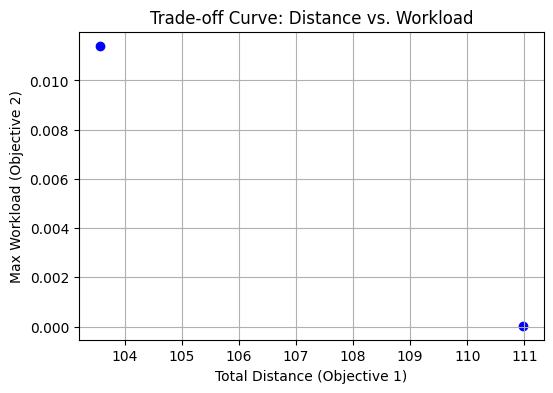

In [20]:
plot_biobj_results(solutions)

## Tri-objective Problem

In [27]:

def solve_triobjective_fixed(total_relocated_offices, epsilon_value):
    """
    Solve the tri-objective problem for:
        - EXACT number of relocated offices = total_relocated_offices
        - MAX WORKLOAD <= epsilon_value
        - MINIMIZE total distance

    Returns a dict with keys:
        'distance'       : objective1 solution 
        'max_workload'   : objective2 solution 
        'relocated_offices': objective3 solution 
        'assignments'    : x[i,j] solution
        'centers'        : c[i,j] solution
    Or None if infeasible.
    """
    model = gb.Model(f"triobj_disrupt_{total_relocated_offices}_eps_{epsilon_value}")
    
    # Decision variables
    x = model.addVars(N, M, vtype=gb.GRB.BINARY, name="x")  # Assign bricks
    c = model.addVars(N, M, vtype=gb.GRB.BINARY, name="c")  # Center bricks
    
    # y[i] = 1 if SR i has relocated its office, 0 otherwise
    y = model.addVars(N, vtype=gb.GRB.BINARY, name="y")

    # ---- 1) Objective 1: total distance ----
    # distance = sum_{i in SR} sum_{k in bricks} sum_{j in bricks}
    #                 distance_sq[k,j] * x[i,j] * c[i,k]
    # We'll store it in a Gurobi expression to set as objective
    distance_expr = gb.quicksum(
        distances[k, j] * x[i, j] * c[i, k]
        for i in range(N)
        for k in range(M)
        for j in range(M)
    )

    # ---- 2) Objective 2: maximum workload ----
    # workload_i = sum_{j} [workloads[j] * x[i,j]] for i in SR
    # workload_obj = variance of workloads
    # We handle via an ep-constraint approach: workload_obj <= epsilon_value
    workload_exprs = [gb.quicksum(workloads[j] * x[i, j] for j in range(M)) for i in range(N)]
    mean_workload = (1.0 / N) * gb.quicksum(workload_exprs[i] for i in range(N))
    variance_expr = (1.0 / N) * gb.quicksum((workload_exprs[i] - mean_workload)**2 
                                           for i in range(N))
    # Constrain each workload_i <= max_workload_var
    # for i in range(N):
    #     model.addConstr(workload_exprs[i] <= max_workload_var, name=f"WorkloadLink_{i}")

    # ---- 3) Objective 3: number of relocated offices ----
    # distruption_objective = sum_i y[i], forcibly set to "total_relocated_offices"
    # That means we fix the total number of relocated offices to a specific integer
    disruption_expr = gb.quicksum(y[i] for i in range(N))
    model.addConstr(disruption_expr == total_relocated_offices, name="FixedRelocatedOffices")

    # We link y[i] to whether center i is changed:
    for i in range(N):
        for j in range(M):
            # If c[i,j] differs from sr_center_initial[i][j], then y[i] = 1
            # Implementing constraints: y[i] >= c[i,j] - sr_center_initial[i][j]
            #                            y[i] >= sr_center_initial[i][j] - c[i,j]
            # The difference c[i,j] - sr_center_initial[i,j] can be -1,0, or 1
            model.addConstr(y[i] >= c[i, j] - sr_center_initial[i][j], name=f"RelocPos_{i}_{j}")
            model.addConstr(y[i] >= sr_center_initial[i][j] - c[i, j], name=f"RelocNeg_{i}_{j}")

    # ---- Additional constraints ----
    # 1) Each brick assigned to exactly 1 rep
    for j in range(M):
        model.addConstr(gb.quicksum(x[i, j] for i in range(N)) == 1, name=f"OneRepPerBrick_{j}")

    # 2) Exactly 1 center brick per SR
    for i in range(N):
        model.addConstr(gb.quicksum(c[i, k] for k in range(M)) == 1, name=f"OneCenterPerSR_{i}")

    # 3) Workload bounds (0.8 <= workload <= 1.2)
    for i in range(N):
        model.addConstr(workload_exprs[i] >= 0.8, name=f"MinWorkload_{i}")
        model.addConstr(workload_exprs[i] <= 1.2, name=f"MaxWorkload_{i}")

    # ---- \epsilon-constraint on workload_obj ----
    model.addConstr(variance_expr  <= epsilon_value, name="EpsConstraint_Workload")

    # ---- Set objective to minimize total distance ----
    model.setObjective(distance_expr, gb.GRB.MINIMIZE)

    # Solve
    model.optimize()

    # If optimal solution found, collect it
    if model.status == gb.GRB.OPTIMAL:
        sol_distance = distance_expr.getValue()              # distance_objective
        sol_maxworkload = variance_expr.getValue()                # workload_objective
        sol_disruption = total_relocated_offices             # distruption_objective

        # Extract assignment & centers
        x_sol = np.array([[x[i, j].X for j in range(M)] for i in range(N)])
        c_sol = np.array([[c[i, j].X for j in range(M)] for i in range(N)])

        return {
            'distance': sol_distance,
            'max_workload': sol_maxworkload,
            'relocated_offices': sol_disruption,
            'assignments': x_sol,
            'centers': c_sol
        }

    return None  # Infeasible or unbounded

In [28]:

def triobjective_solutions(distances, workloads, sr_center_initial):
    """
    Collect solutions across all possible relocated_offices = 0..N
    For each, do an epsilon-constraint loop over max workload .
    Return a list of all feasible (dist, workload, disrupt) solutions plus assignments.
    """

    solutions = []
    # For each possible integer from 0 to N
    for relocated_offices_count in range(N + 1):
        # We'll start from a large epsilon, 
        # move downward each time we find a feasible solution (the same approach as your biobj code).
        epsilon = float('inf')
        while True:
            result = solve_triobjective_fixed(
                total_relocated_offices=relocated_offices_count,
                epsilon_value=epsilon
            )
            if result is None:
                # No feasible solution for epsilon -> break from that loop
                break            
            solutions.append(result)

            # Update epsilon to be just below the best max_workload found
            new_eps = result['max_workload'] - 0.01
            if new_eps < 0:
                break
            epsilon = new_eps

    return solutions

Actually compute the tri-objective solution

In [29]:
tri_solutions = triobjective_solutions(distances, workloads, sr_center_initial)

print(f"Number of solutions found: {len(tri_solutions)}")
for sol in tri_solutions:
    print(f"Distance={sol['distance']:.3f}, "
          f"Max Workload={sol['max_workload']:.3f}, "
          f"Relocations={sol['relocated_offices']}")

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 211 rows, 180 columns and 708 nonzeros
Model fingerprint: 0x5db812e0
Model has 1848 quadratic objective terms
Model has 1 quadratic constraint
Variable types: 0 continuous, 180 integer (180 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  QMatrix range    [2e-04, 1e-01]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
  QRHS range       [1e+100, inf]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 181 rows and 92 columns
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 26

In [32]:
len(tri_solutions)

10

In [33]:
def plot_triobjective_solutions(solutions):
    """
    Plot the solution set in 3D: X=distance, Y=max_workload, Z=relocated_offices
    """
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    obj1_vals = [sol['distance'] for sol in solutions]
    obj2_vals = [sol['max_workload'] for sol in solutions]
    obj3_vals = [sol['relocated_offices'] for sol in solutions]

    sc = ax.scatter(obj1_vals, obj2_vals, obj3_vals, c=obj3_vals, cmap='viridis', s=50)

    ax.set_xlabel('Total Distance')
    ax.set_ylabel('Max Workload')
    ax.set_zlabel('Relocated Offices')
    plt.title('Tri-objective Solutions')
    plt.colorbar(sc, label='Relocated Offices')
    plt.show()


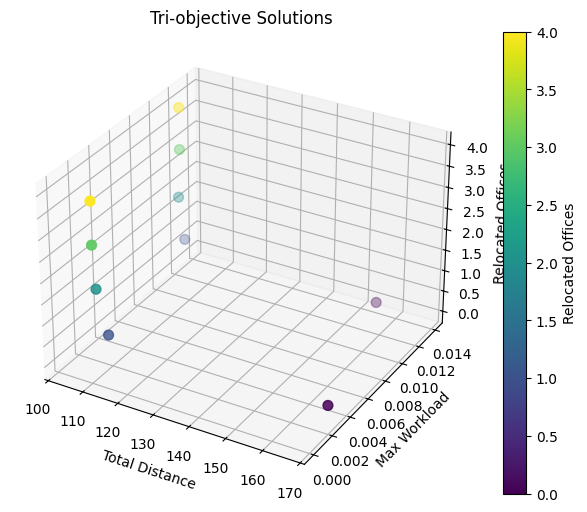

In [34]:
plot_triobjective_solutions(tri_solutions)

Filtering for non dominated solutions

In [35]:
def is_dominated(s1, s2):
    """
    Returns True if solution s1 is dominated by solution s2
    for the three objectives (distance, max_workload, relocated_offices).
    s1 is dominated if s2 is strictly better or equal on all objectives 
    and strictly better on at least one objective.
    
    For a minimization problem, "better or equal" means 
      s2[obj] <= s1[obj]
    and "strictly better on at least one" means 
      s2[obj] < s1[obj] for some obj.
    """
    better_or_equal = (
        (s2['distance'] <= s1['distance']) and
        (s2['max_workload'] <= s1['max_workload']) and
        (s2['relocated_offices'] <= s1['relocated_offices'])
    )
    strictly_better_one = (
        (s2['distance'] < s1['distance']) or
        (s2['max_workload'] < s1['max_workload']) or
        (s2['relocated_offices'] < s1['relocated_offices'])
    )
    return better_or_equal and strictly_better_one

def filter_pareto_nondominated(solutions):
    non_dom = []
    for s in solutions:
        # check if s is dominated by any solution in the set
        dominated = any(is_dominated(s, other) for other in solutions if other != s)
        if not dominated:
            non_dom.append(s)
    return non_dom

In [36]:
tri_solutions_nd = filter_pareto_nondominated(tri_solutions)
print(f"Non-dominated solutions found: {len(tri_solutions_nd)} out of {len(tri_solutions)} total.")

Non-dominated solutions found: 10 out of 10 total.


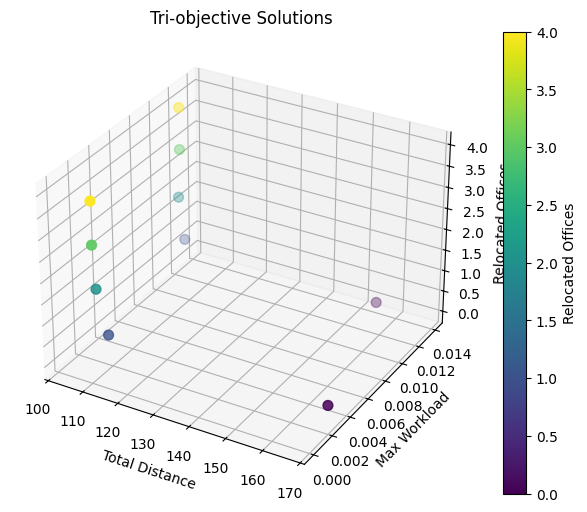

In [37]:
plot_triobjective_solutions(tri_solutions_nd)

In [39]:
def export_solutions_to_csv(solutions, filename="triobjective_solutions.csv"):
    """
    Convert the list of solution dictionaries to a DataFrame and export to CSV.
    """
    out_rows = []
    for idx, sol in enumerate(solutions):
        row = {
            "solution_id": idx,
            "distance": sol['distance'],
            "workload_fairness": sol['max_workload'],
            "relocated_offices": sol['relocated_offices'],
        }
        out_rows.append(row)

    df = pd.DataFrame(out_rows)
    df.to_csv(filename, index=False)
    print(f"Exported {len(df)} solutions to {filename}")


In [40]:
export_solutions_to_csv(tri_solutions, filename="./data/triobjective_var_solutions.csv")


Exported 10 solutions to ./data/triobjective_var_solutions.csv


In [41]:
export_solutions_to_csv(tri_solutions_nd, filename="./data/triobjective_var_nondominated_solutions.csv")


Exported 10 solutions to ./data/triobjective_var_nondominated_solutions.csv
